In [245]:
import os 
import networkx as nx

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from scipy.spatial import distance
import numpy as np

import pandas as pd
import seaborn as sns

import qml
from qml.math import cho_solve
from qml.kernels import gaussian_kernel

def scale_min_max(data, x):
    # print(data)
    # print(x)
    return (x - data.min())/(data.max() - data.min())

def scale_Z(data, x):
    # print(data)
    # print(x)
    return (x - data.mean())/(data.std())


def get_dist_matrix(atoms):
    #https://www.kaggle.com/code/rio114/coulomb-interaction-speed-up/notebook
    num_atoms = len(atoms)
    loc_tile = np.tile(atoms.T, (num_atoms,1,1))
    dist_mat = np.sqrt((loc_tile - loc_tile.T)**2).sum(axis=1)
    return dist_mat

def dihedral3(p):
    b = p[:-1] - p[1:]
    b[0] *= -1
    v = np.array( [np.cross(v,b[1]) for v in [b[0], b[2]] ] )
    # Normalize vectors
    v /= np.sqrt(np.einsum('...i,...i', v, v)).reshape(-1,1)
    return np.degrees(np.arccos( v[0].dot(v[1]) ))


def angle(p):
    ba = p[0] - p[1]
    bc = p[2] - p[1]
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    a3 = np.degrees(np.arccos(cosine_angle))
    return a3

def load_nc(path):
    #  load nuclear coordinates
    nc_lines = open(path).readlines()[6:12]
    ncs = [[float(y) for y in x.split()[2:]] for x in nc_lines]
    return ncs



In [246]:
pkl_path = "pickles"
pickles = os.listdir(pkl_path)

lcs = {}

for obj in pickles:
    key = int(obj.split("_")[0])
    pkl = pd.read_pickle(os.path.join(pkl_path, obj))
    lcs[key] = pkl[np.mod(np.arange(pkl.size)+1, 4) != 0]
    
print(len(lcs.keys()))


867


In [247]:
# lcs[1]

In [248]:
# lcs[427].reshape((6,6))


In [249]:
df = pd.DataFrame(lcs)
df = df.T
# df

In [250]:
ncs = []

for index, row in df.iterrows():
    _path_ = f"/data/unibas/boittier/graphscan/methanol/t3/p{index}.p.cube"
    ncs.append(load_nc(_path_))
    
dms = [get_dist_matrix(np.array(x)) for x in ncs]

In [251]:
flat_dms = [x.flatten() for x in dms]

In [252]:
X = np.zeros((len(df),36))
for i, mat in enumerate(flat_dms):
    for j, mi in enumerate(mat):
        # X[i][j] = mi
        # X[i][j] = scale_min_max(mat, mi)
        X[i][j] = scale_Z(mat, mi)
print(X[0])

[-1.76724341 -0.47617033 -0.59105427  0.91682161  0.62562993  0.95950757
 -0.47617033 -1.76724341  0.40927865 -0.37425147 -0.37470299 -0.31044959
 -0.59105427  0.40927865 -1.76724341  1.13993969  1.80181907  0.7699219
  0.91682161 -0.37425147  1.13993969 -1.76724341  0.26561848  0.23502748
  0.62562993 -0.37470299  1.80181907  0.26561848 -1.76724341  0.30479451
  0.95950757 -0.31044959  0.7699219   0.23502748  0.30479451 -1.76724341]


In [253]:
# _X = np.zeros((len(df),15))

# for i in range(len(df)):
#     iu1 = np.triu_indices(6)
#     _ = X[i].reshape((6,6))
#     uptri = _[iu1]
#     _X[i] = uptri[uptri != 0]
#     _X[i] = scale_min_max(_X[i],_X[i])
    
# _X[0]

In [254]:
X = _X

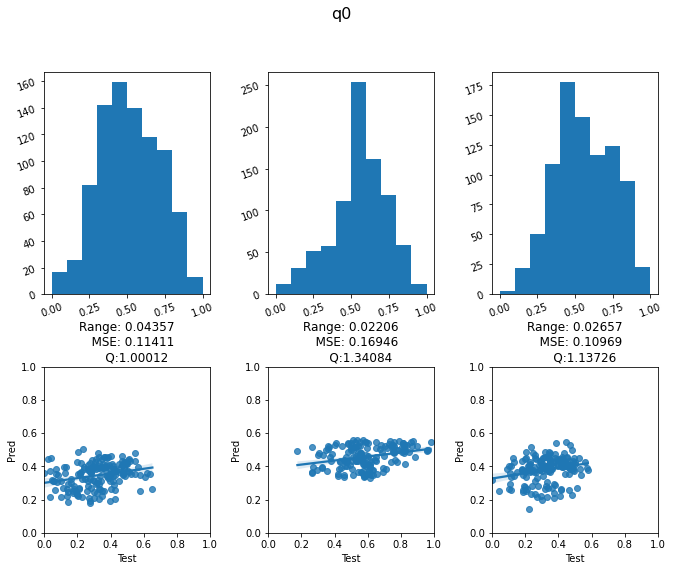

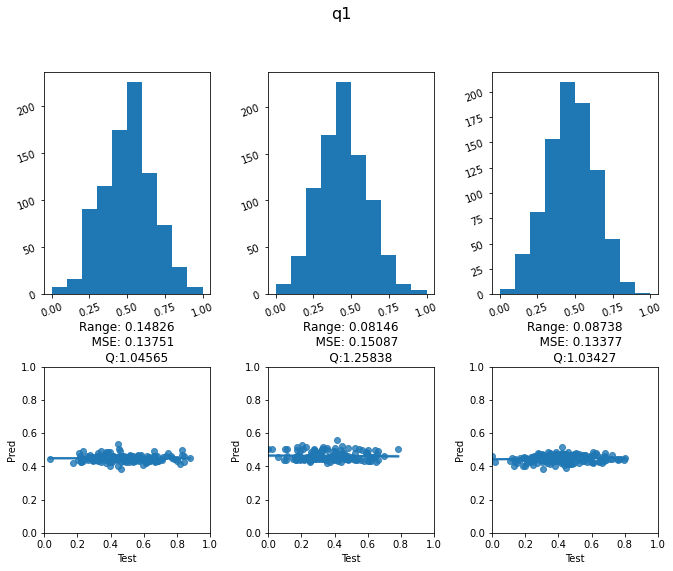

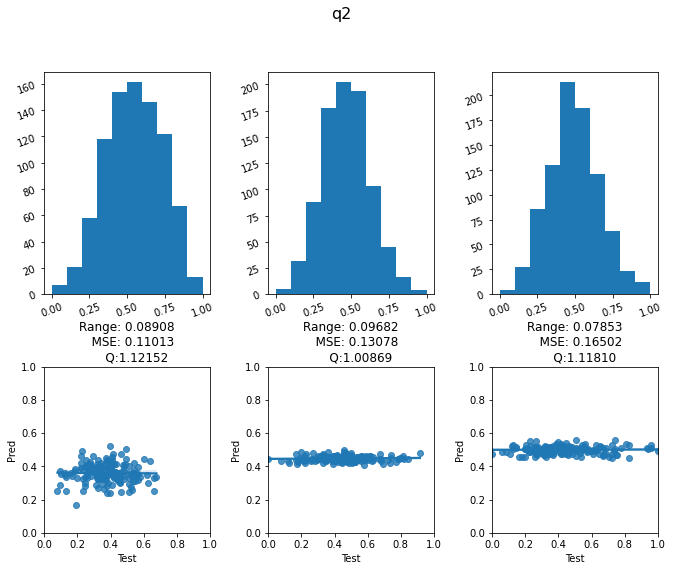

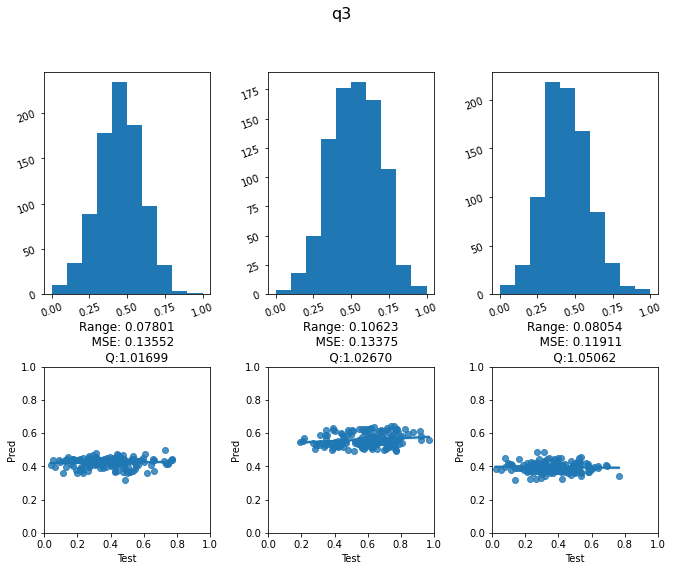

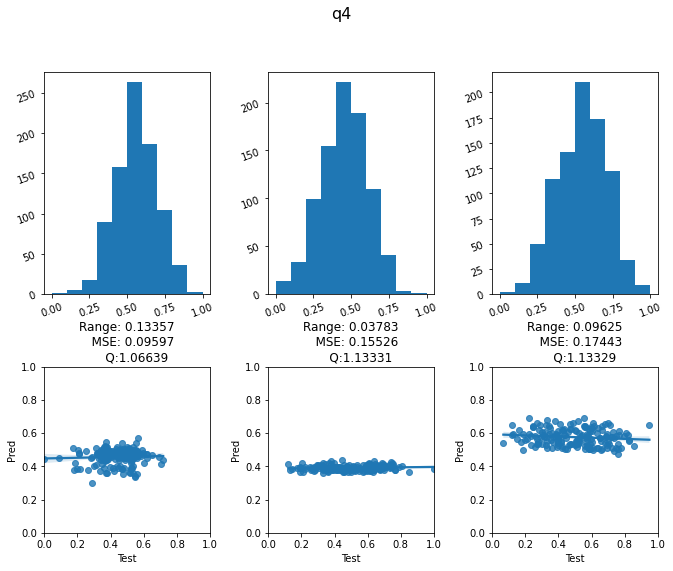

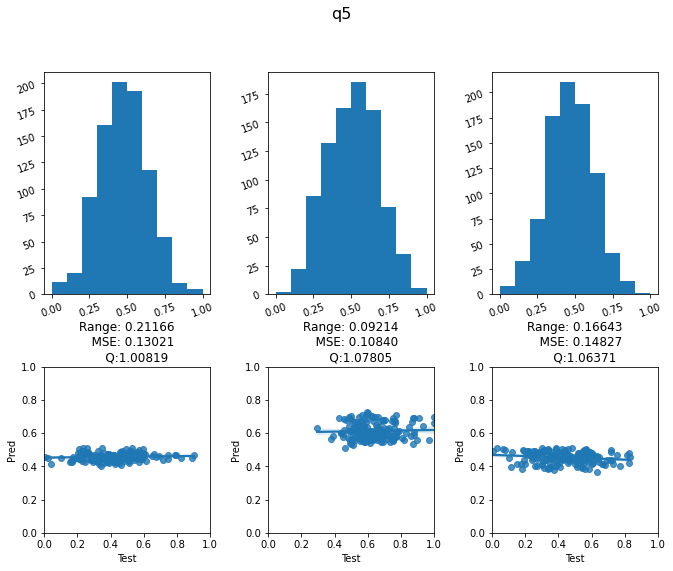

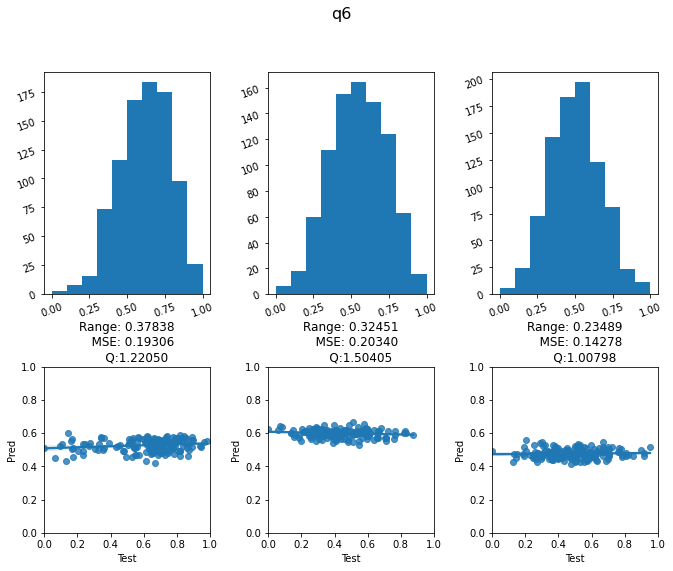

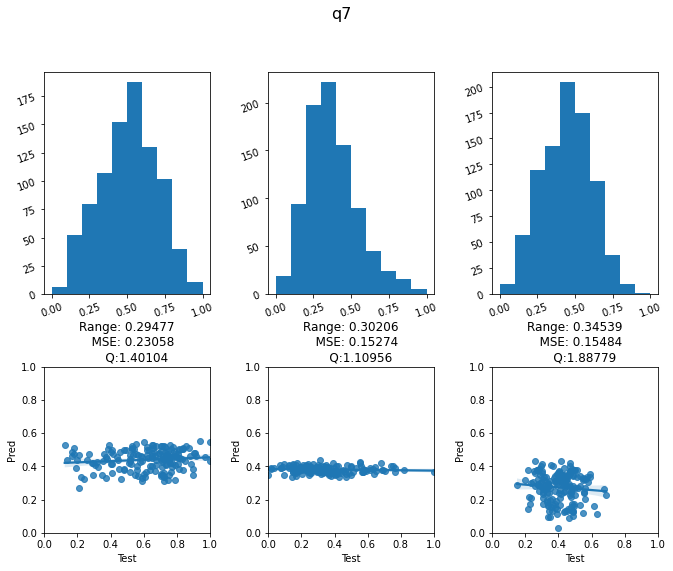

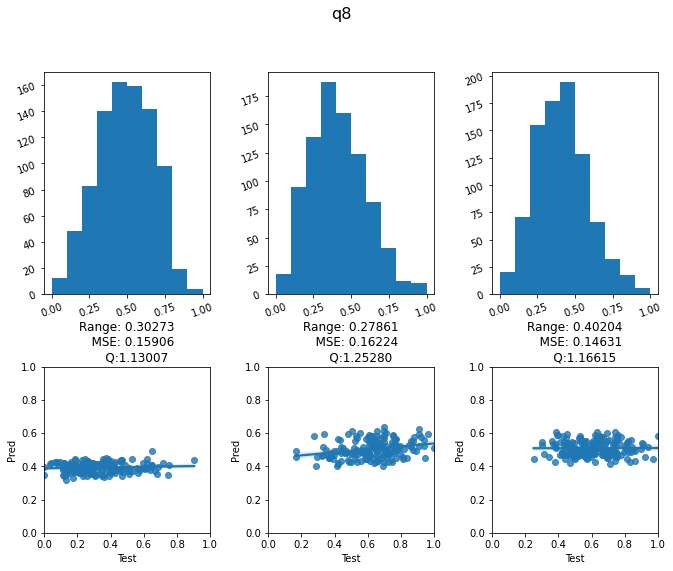

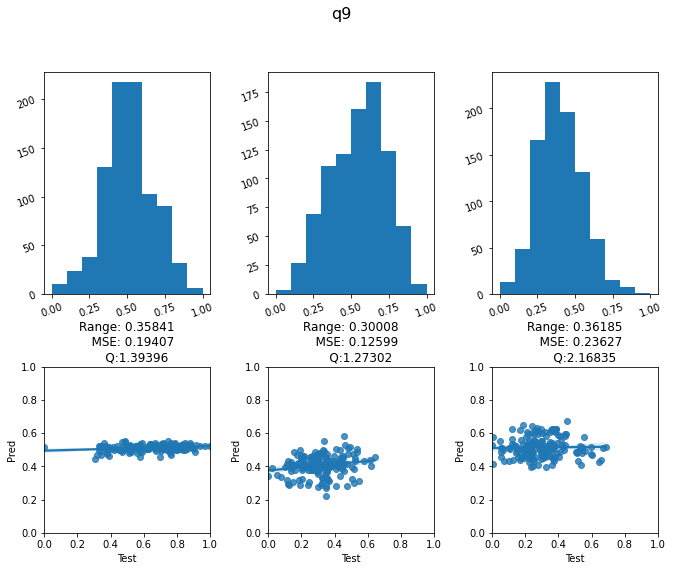

In [255]:
ind_slice = 700

for charge in range(10):

    fig, ax = plt.subplots(
        2,3, figsize=(11,9),
        gridspec_kw={"hspace": 0.2, "wspace": 0.35}
    )


    # Assign 1000 first molecules to the training set
    X_training = _X[:ind_slice]
    X_test = _X[ind_slice:]

    sigma = 4000.0
    K = gaussian_kernel(X_training, X_training, sigma)
    # Add a small lambda to the diagonal of the kernel matrix
    K[np.diag_indices_from(K)] += 1e-8

    # calculate a kernel matrix between test and training data, using the same sigma
    Ks = gaussian_kernel(X_test, X_training, sigma)

    # plotting regression
    
    fig.suptitle(f'q{charge}', fontsize=16)

    for axis in range(3):
        df_inx = charge*3+axis
        y = np.array([x for x in df[df_inx]]) 
        
        y_orig = y.copy()
        y = (y - np.mean(y))/np.std(y)
        y = (y - y.min()) / (y.max() - y.min())

        ax[0,axis].hist(y)
        ax[0,axis].tick_params(labelrotation=20)

        Y_training = y[:ind_slice]
        Y_test = y[ind_slice:]

        # Use the built-in Cholesky-decomposition to solve
        alpha = cho_solve(K, Y_training)

        # Make the predictions
        Y_predicted = np.dot(Ks, alpha)

        MSE = np.mean(np.abs(Y_predicted - Y_test))
        MSE_test = np.mean(np.abs(Y_test.mean() - Y_test))

        all_data = np.append(Y_predicted, Y_test, axis=0)
        _min = min(all_data)
        _max = max(all_data)

        sns.regplot(x=Y_test, y=Y_predicted, ax=ax[1,axis])
        
        _range = y_orig.max() - y_orig.min()
        
        ax[1,axis].set_title("Range: {:.5f}\n   MSE: {:.5f}\n     Q:{:.5f}".format(_range,MSE,MSE/MSE_test))
        ax[1,axis].set_ylabel("Pred")
        ax[1,axis].set_xlabel("Test")
        ax[1,axis].set_box_aspect(1)
        ax[1,axis].set_xlim(0, 1)
        ax[1,axis].set_ylim(0, 1)

    plt.savefig(f"KR_methanol_{charge}.pdf", bbox_inches="tight")